In [1]:
from pacha.utils import instruments as iutils
from pacha.visualisation import geospatial as gvis
from pacha.visualisation import statistical as svis
from pacha.L1_processing import common as l1com
from pacha.data_sources import satellite_loaders as sload
from pacha.utils import geospatial as gutils
from pacha.utils import scores as sutils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

import importlib
importlib.reload(iutils)
importlib.reload(gvis)
importlib.reload(l1com)
importlib.reload(sload)
importlib.reload(gutils)
importlib.reload(svis)

<module 'pacha.visualisation.statistical' from '/home/admingosset/WORK/code/PACHA/pacha/visualisation/statistical.py'>

In [2]:
# create function that from satv7, satv6 and radar it makes the merged dataset
def create_merged_dataset(satv7, satv6, imv6_qmp, radar, date):
    v7_sample = sload.load_v7_by_date(satv7, date)
    v6_sample = satv6.load_sample(2, str(date))
    rd_sample = radar.load_sample(2, str(date))
    imv6_qmp_sample = imv6_qmp.load_sample(2, str(date))

    # normalize datasets
    v7_sample = l1com.normalize_geospatial_ds(v7_sample)
    v6_sample = l1com.normalize_geospatial_ds(v6_sample)
    rd_sample = l1com.normalize_geospatial_ds(rd_sample)
    imv6_qmp_sample = l1com.normalize_geospatial_ds(imv6_qmp_sample)

    bbox_v6 = gutils.get_bbox_from_xarray(v6_sample)
    bbox_v7 = gutils.get_bbox_from_xarray(v7_sample)
    bbox_rad = gutils.get_bbox_from_xarray(rd_sample)
    bbox_imv6_qmp = gutils.get_bbox_from_xarray(imv6_qmp_sample)

    bboxes = [bbox_rad, bbox_v6, bbox_v7, bbox_imv6_qmp]

    min_lats = [i.min_lat for i in bboxes]
    min_lons = [i.min_lon for i in bboxes]
    max_lats = [i.max_lat for i in bboxes]
    max_lons = [i.max_lon for i in bboxes]

    # calculate biggest intersecting square with all of the bboxes
    biggest_intersecting_bbox = {
        'min_lat': max(min_lats),
        'min_lon': max(min_lons),
        'max_lat': min(max_lats),
        'max_lon': min(max_lons)
    }

    # define common bbox
    common_bbox = gutils.BBox(**biggest_intersecting_bbox)

    bboxed_v6 = gutils.get_data_in_bbox(v6_sample, common_bbox)
    bboxed_v7 = gutils.get_data_in_bbox(v7_sample, common_bbox)
    bboxed_rad = gutils.get_data_in_bbox(rd_sample, common_bbox)
    bboxed_imv6_qmp = gutils.get_data_in_bbox(imv6_qmp_sample, common_bbox)

    mask = ~ np.isnan(bboxed_rad).isel(time=0).rain_rate

    masked_v6 = bboxed_v6.where(mask)
    masked_v7 = bboxed_v7.where(mask)
    masked_rad = bboxed_rad.where(mask)
    masked_imv6_qmp = bboxed_imv6_qmp.where(mask)
    masked_imv6_qmp = masked_imv6_qmp.drop_vars('HQprecipitation')
    masked_imv6_qmp = masked_imv6_qmp.rename_vars({'precipitationCal': 'imerg_v6_qmp'})

    merged = xr.merge([masked_v6, masked_v7, masked_rad, masked_imv6_qmp], join='inner')

    merged = merged.rename_vars({'precipitationCal': 'imerg_v6',
                                    'precipitation': 'imerg_v7',
                                    'rain_rate': 'radar_rain_rate'})
    
    return merged


In [3]:
satv6 = iutils.SPP('IMERG_v06', 'imerg_v06')
sat_dir = '/home/admingosset/WORK/projects/pacha_dev/dataset/imerg_v6/'
satv6.build_catalog(2, sat_dir, date_char_st=19, date_char_nd=29, date_format='%Y_%m_%d')

satv7 = iutils.SPP('IMERG_v07', 'imerg_v07')
sat_dir_v7 = '/home/admingosset/WORK/projects/pacha_dev/dataset/imerg_v7/'
satv7.build_catalog(2, sat_dir_v7)

gauges_dpath = '/home/admingosset/WORK/projects/pacha_dev/dataset/gauges/v3/gauges_6min_utc.csv'
gauges_mpath = '/home/admingosset/WORK/projects/pacha_dev/dataset/gauges/v3/gauges_6min_utc_metadata.csv'

radar_l2_sat_dir = '/home/admingosset/WORK/projects/pacha_dev/dataset/radar/L2_sat_resolution/'
radar = iutils.Radar('guyane', 'romuald_bufr')
radar.build_catalog(2, radar_l2_sat_dir, date_char_st=16, date_char_nd=24, date_format='%Y%m%d')

v6qmp = iutils.SPP('IMERG_v06_QMPE', 'imerg_v06_qmpe')
v6qmp_dir = '/home/admingosset/WORK/projects/pacha_dev/dataset/im_v6_qmp/'
v6qmp.build_catalog(2, v6qmp_dir, date_char_st=17, date_char_nd=27, date_format='%Y_%m_%d')

gauges = iutils.Gauges(gauges_dpath, gauges_mpath)

In [4]:
# Filter out interesting data days

conditionnal_avg_daily_acc = gauges.data.loc['2019':].groupby(pd.Grouper(freq='D')).sum(min_count=200).mean(axis=1)
dates_over_10mm = conditionnal_avg_daily_acc[conditionnal_avg_daily_acc > 10].index.to_list()
dates_over_10mm = [pd.to_datetime(date).date() for date in dates_over_10mm]

In [5]:
dates_radar = [i.date() for i in radar.l2_catalog.index]
dates_satv6 = [i.date() for i in satv6.l2_catalog.index]
dates_satv7 = [i.date() for i in satv7.l2_catalog.index]
dates_v6qmp = [i.date() for i in v6qmp.l2_catalog.index]

# get intersection of dates from radar, v6 and v7 sat and over 10mm dates

dates_intersect = sorted(list(set(dates_over_10mm).intersection(set(dates_radar).intersection(set(dates_satv6).intersection(set(dates_satv7).intersection(set(dates_v6qmp)))))))

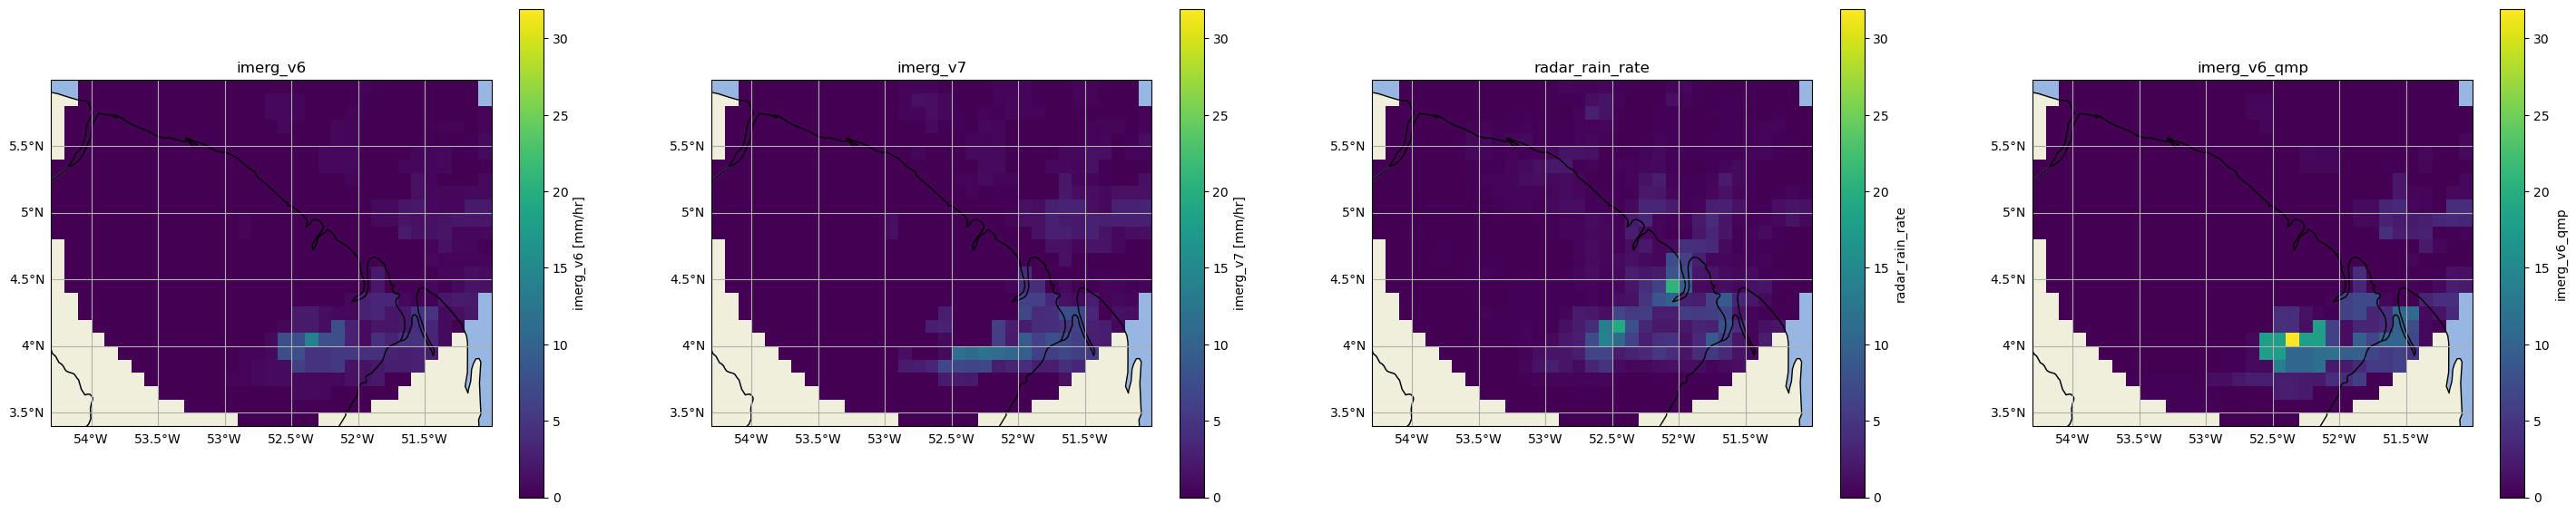

In [6]:
date = dates_intersect[1]

ds = create_merged_dataset(satv7, satv6, v6qmp, radar, date)
gvis.plot_ds(ds.isel(time=0))


Processing date: 2019-01-09


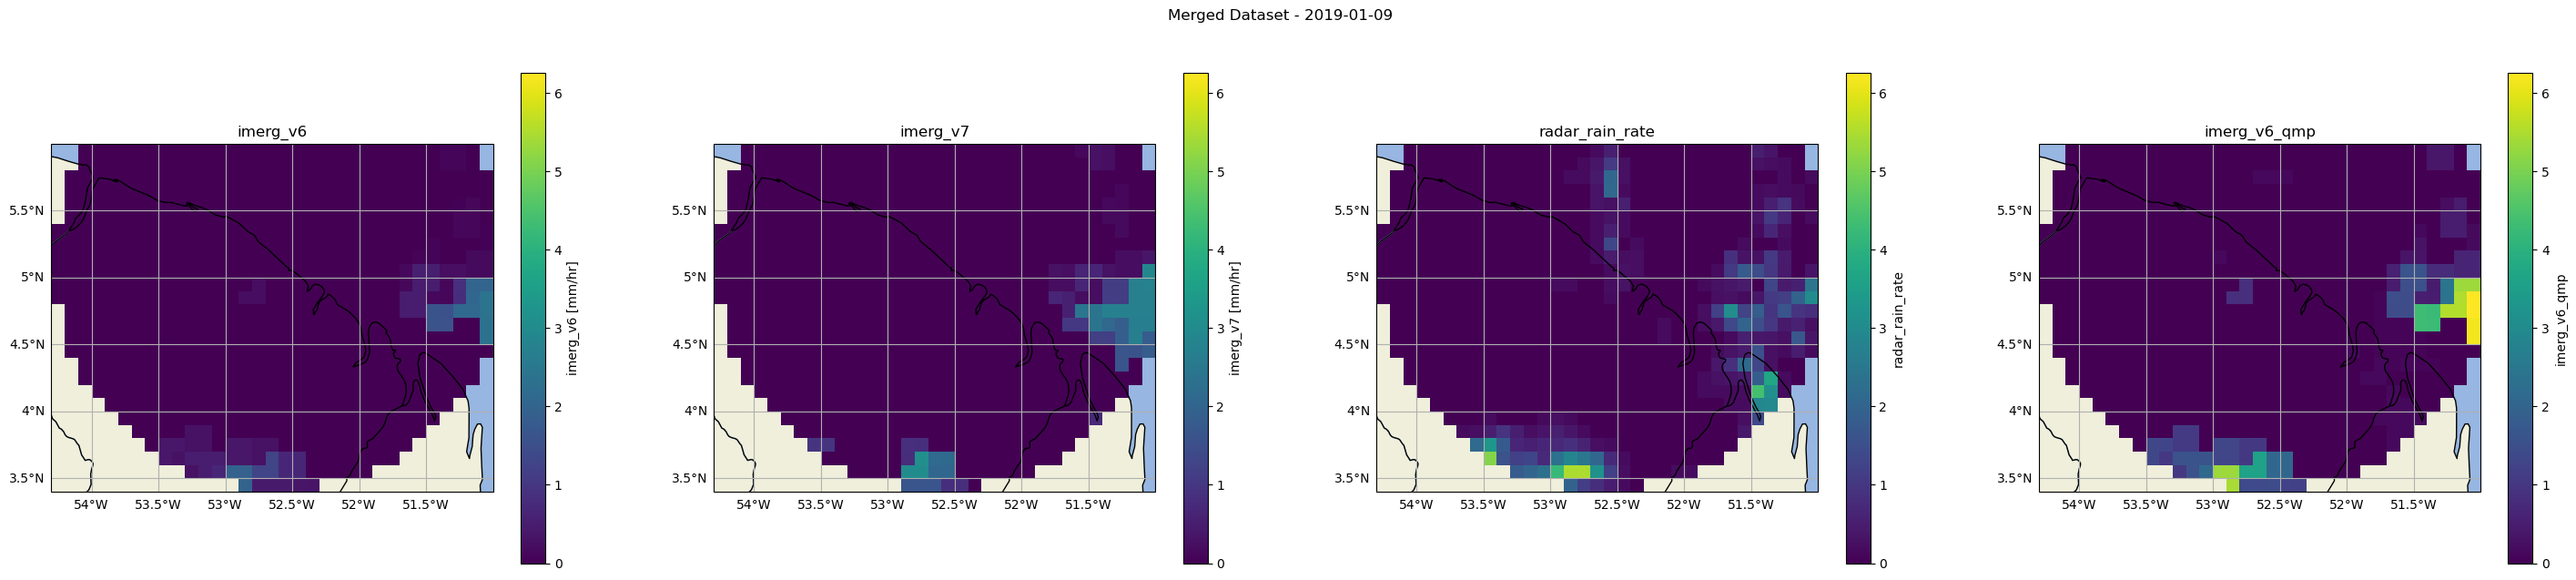

Processing date: 2019-01-30


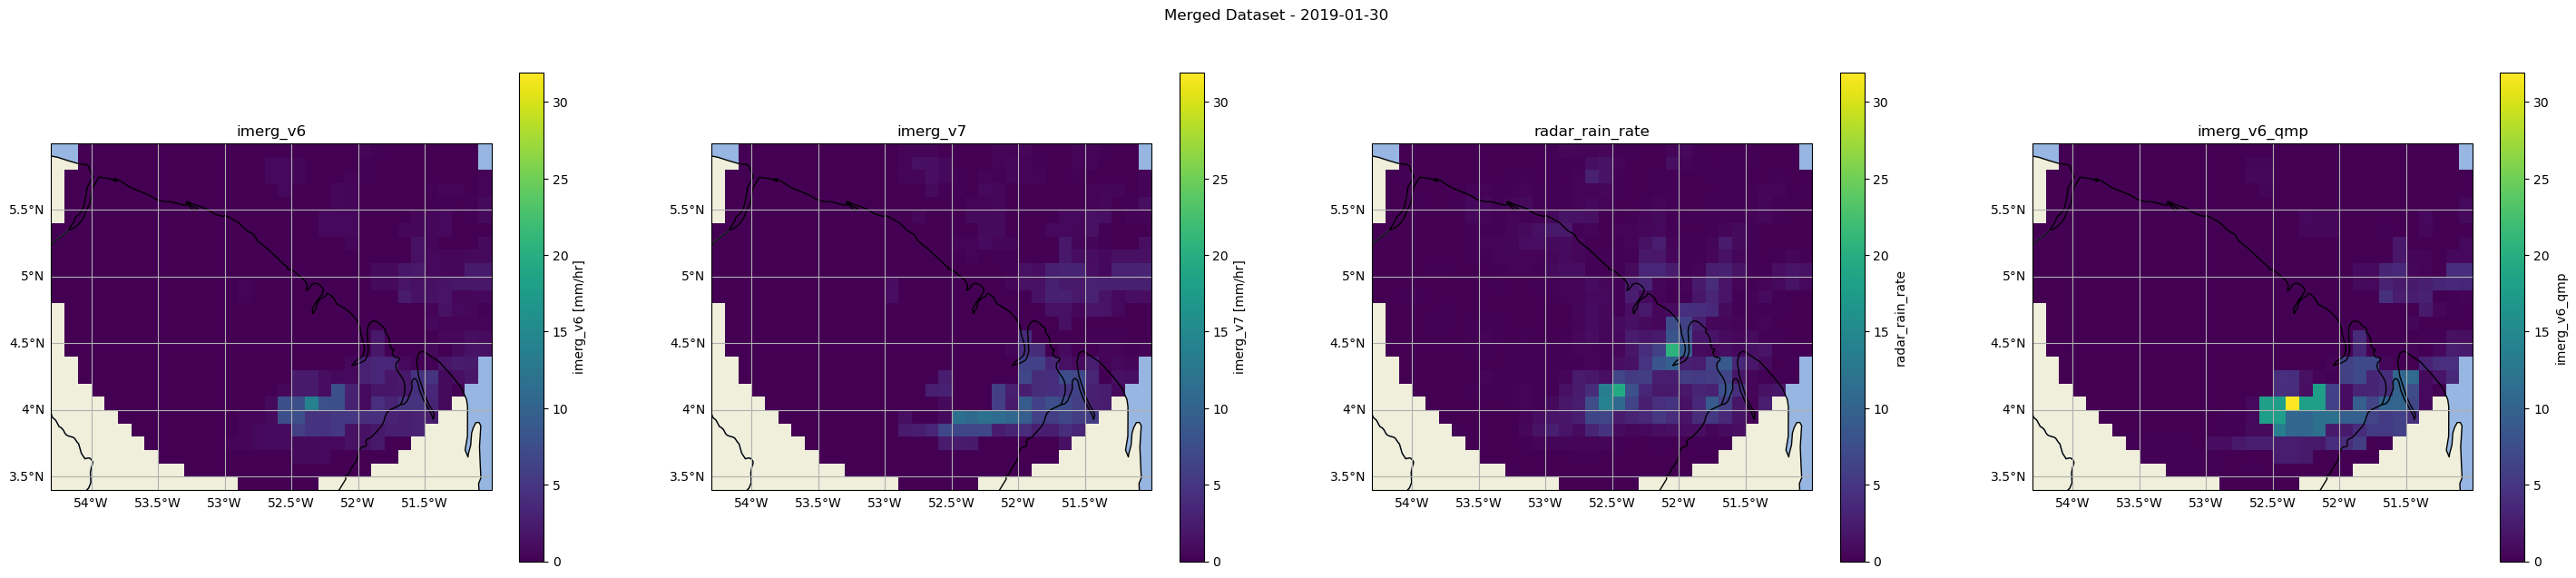

Processing date: 2019-02-01


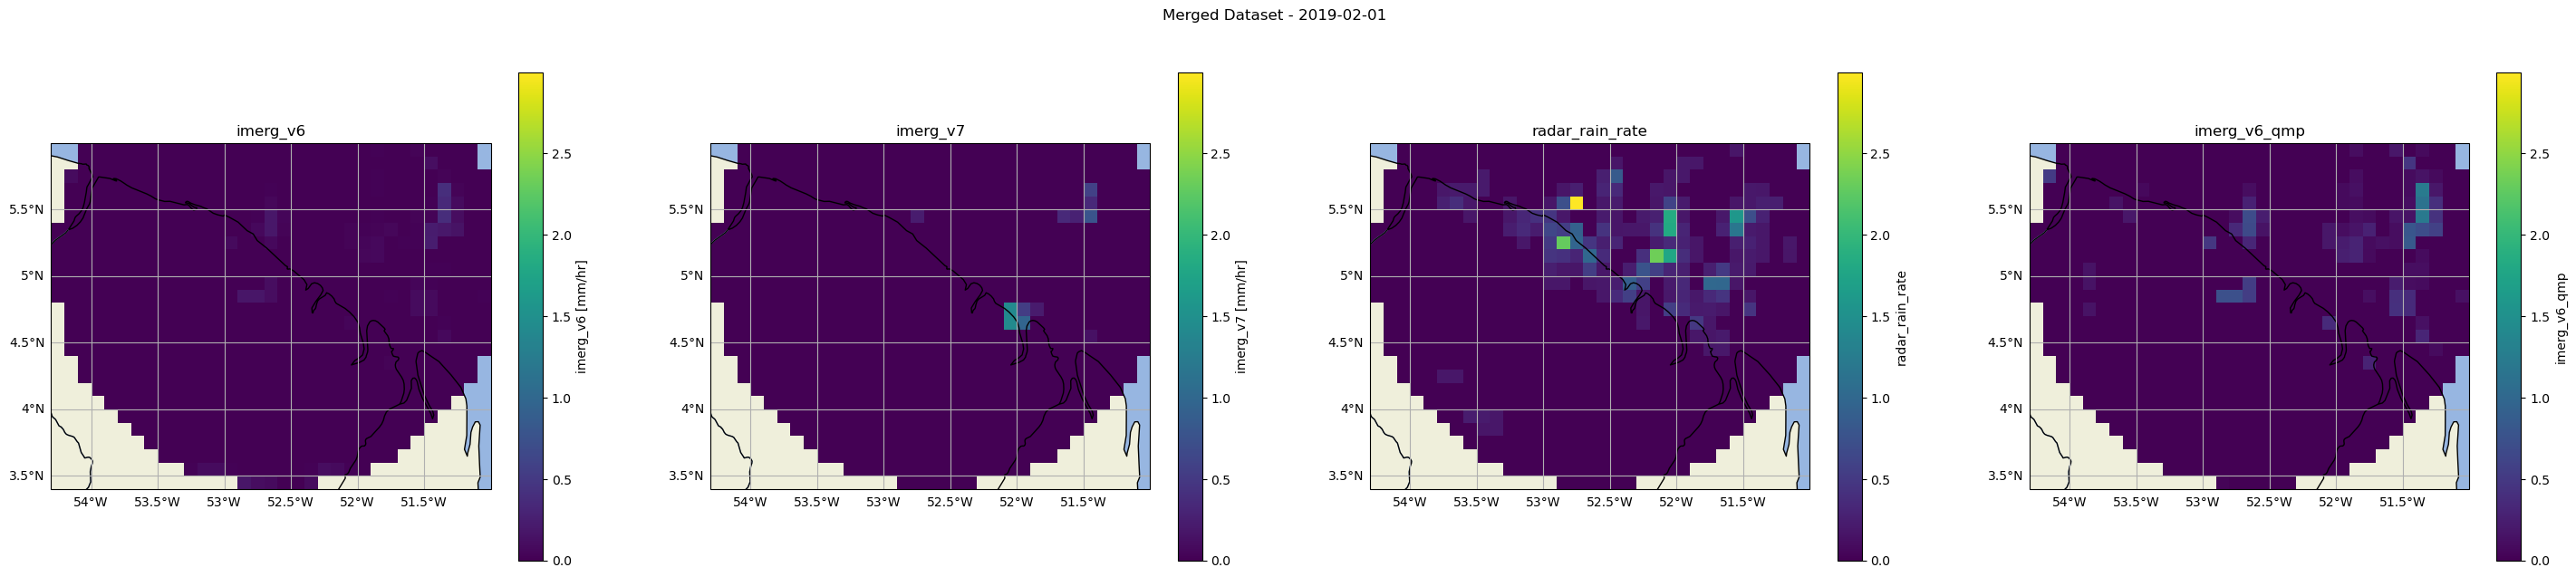

Processing date: 2019-04-05


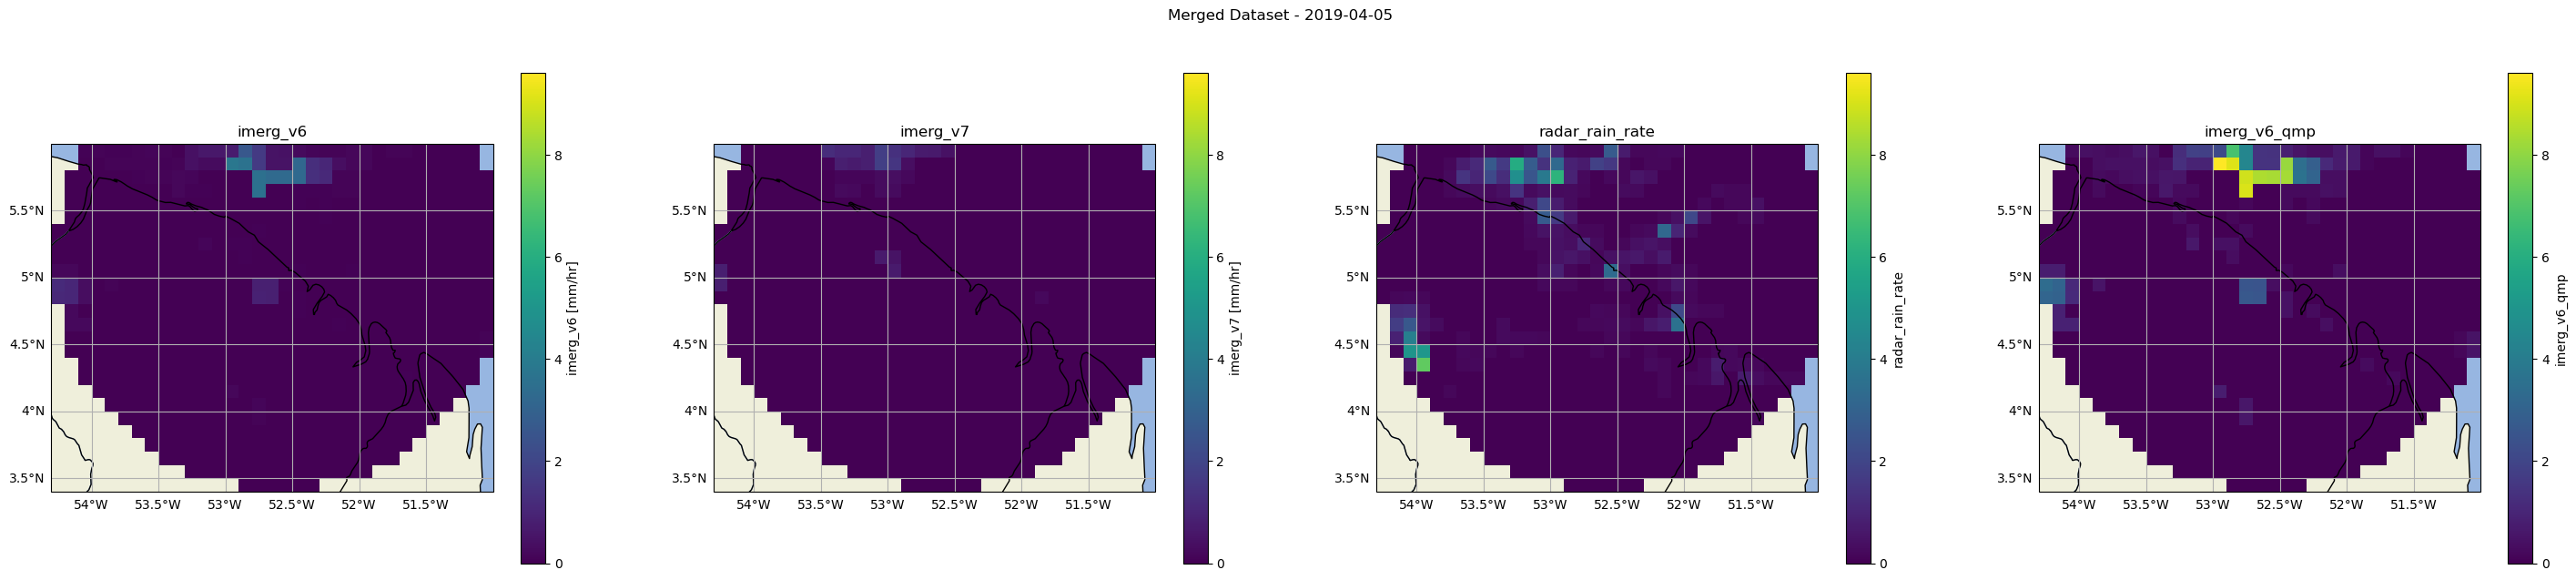

Processing date: 2019-04-09


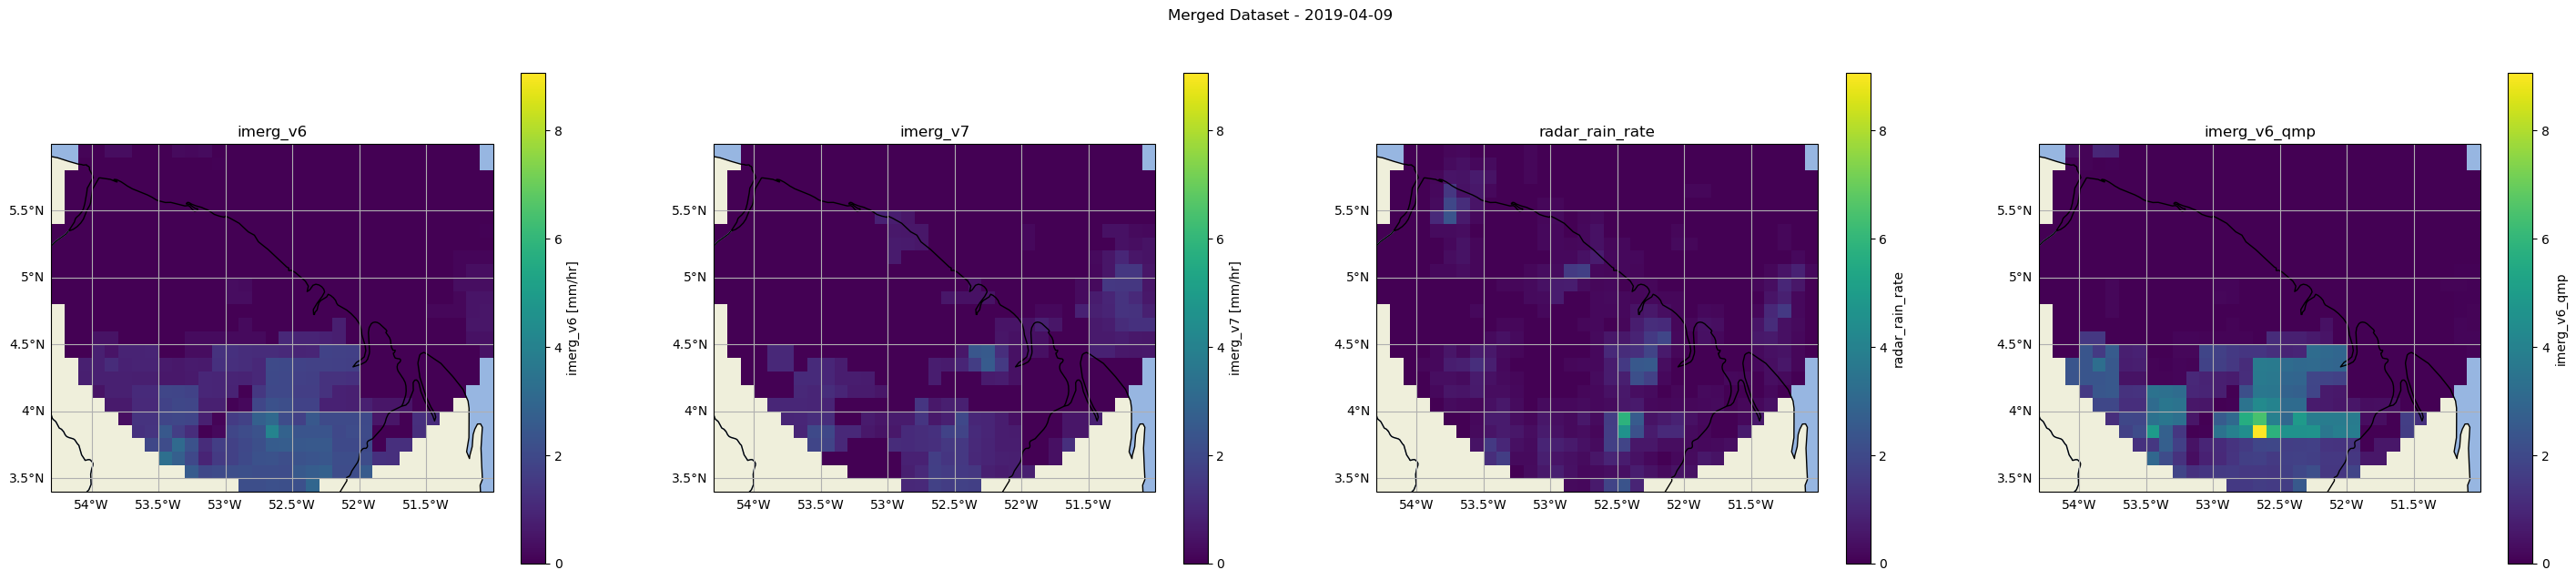

Processing date: 2019-04-23


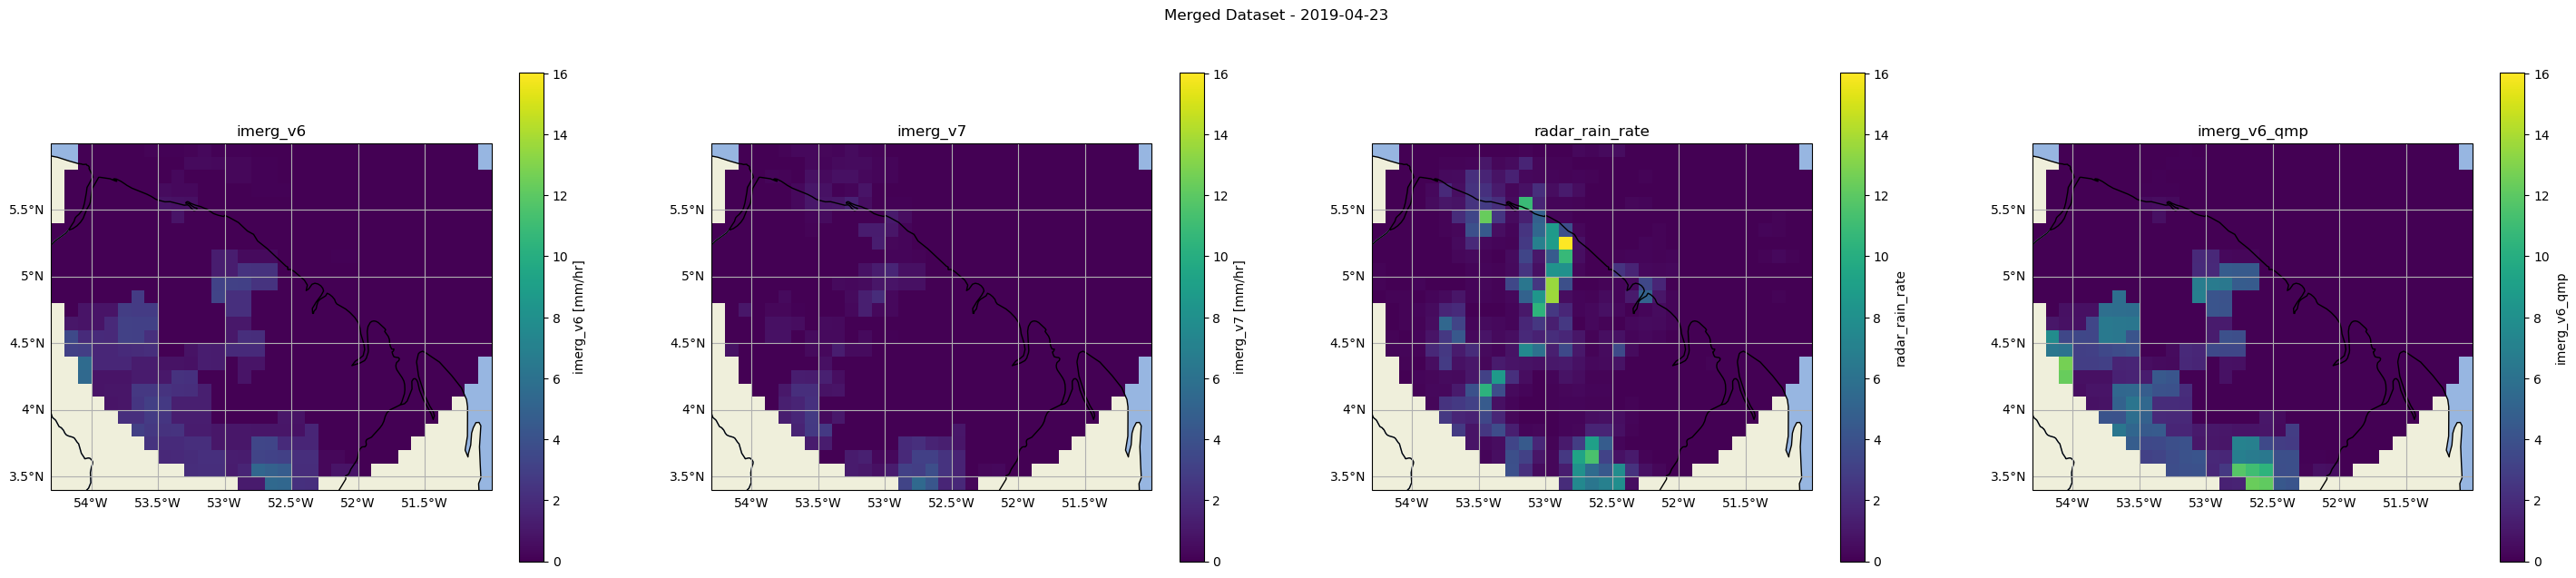

Processing date: 2019-05-01


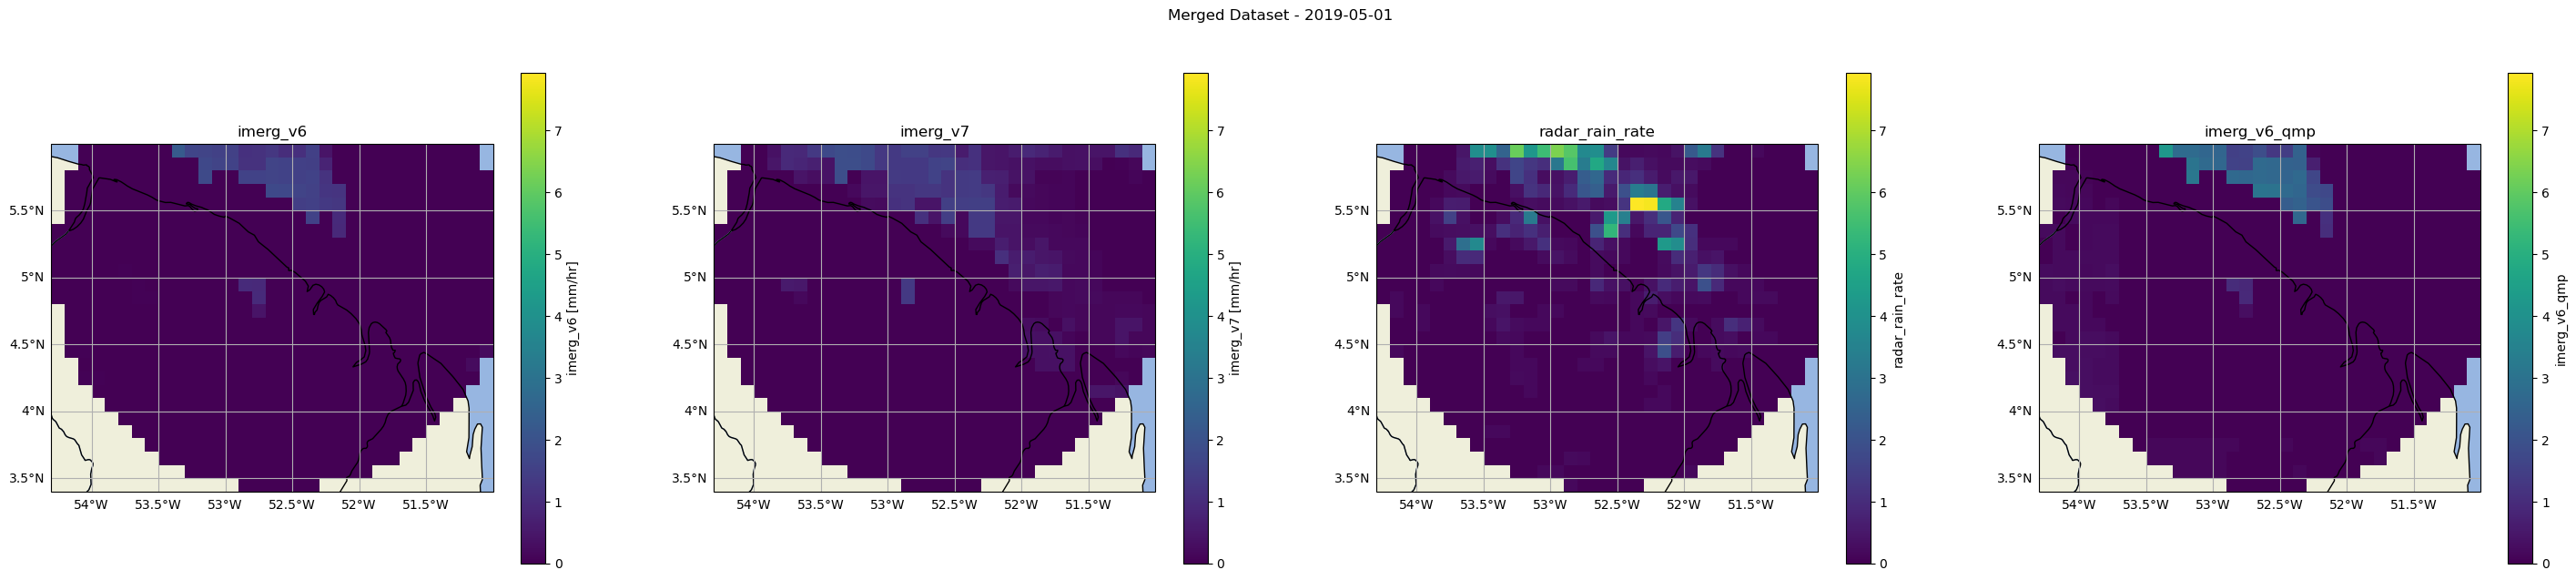

Processing date: 2019-05-09


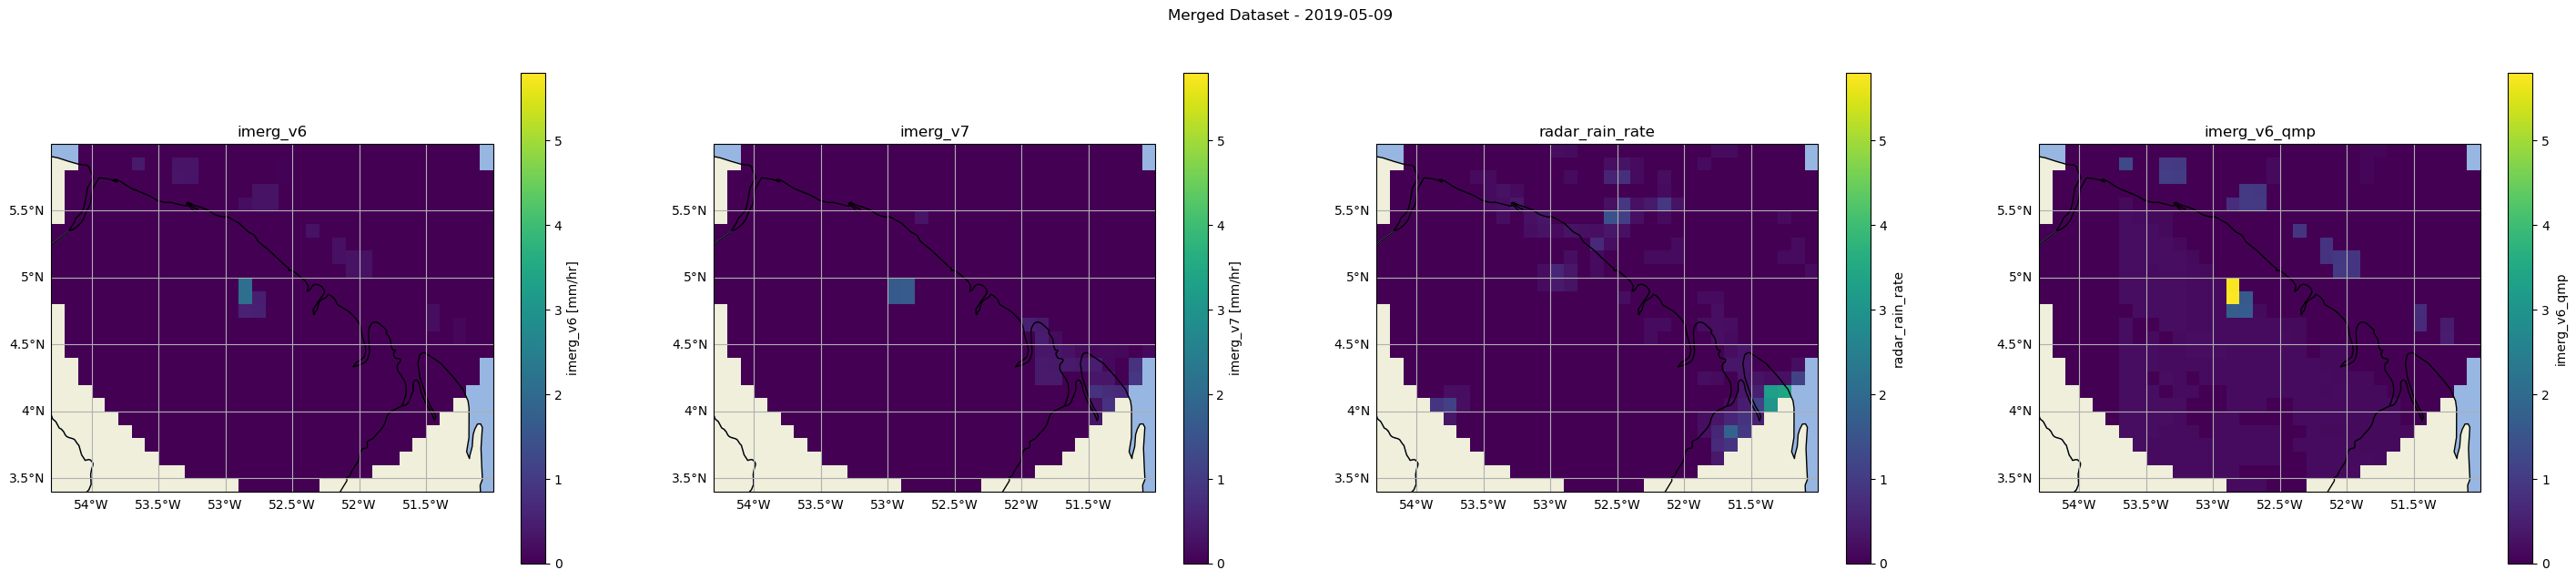

Processing date: 2019-05-11


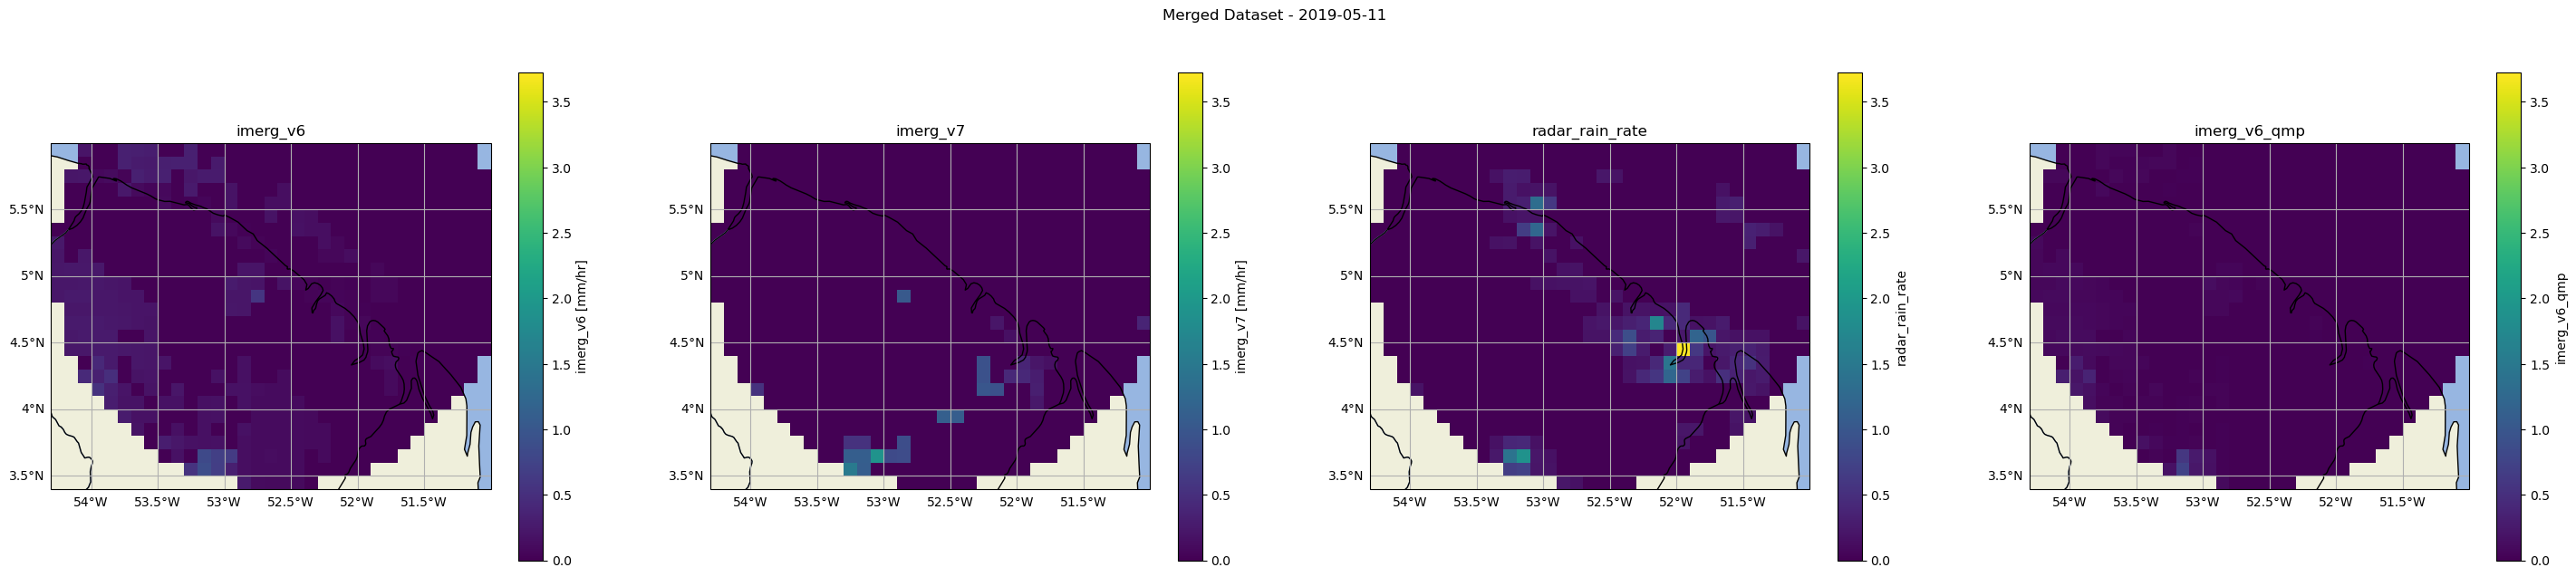

Processing date: 2019-05-15


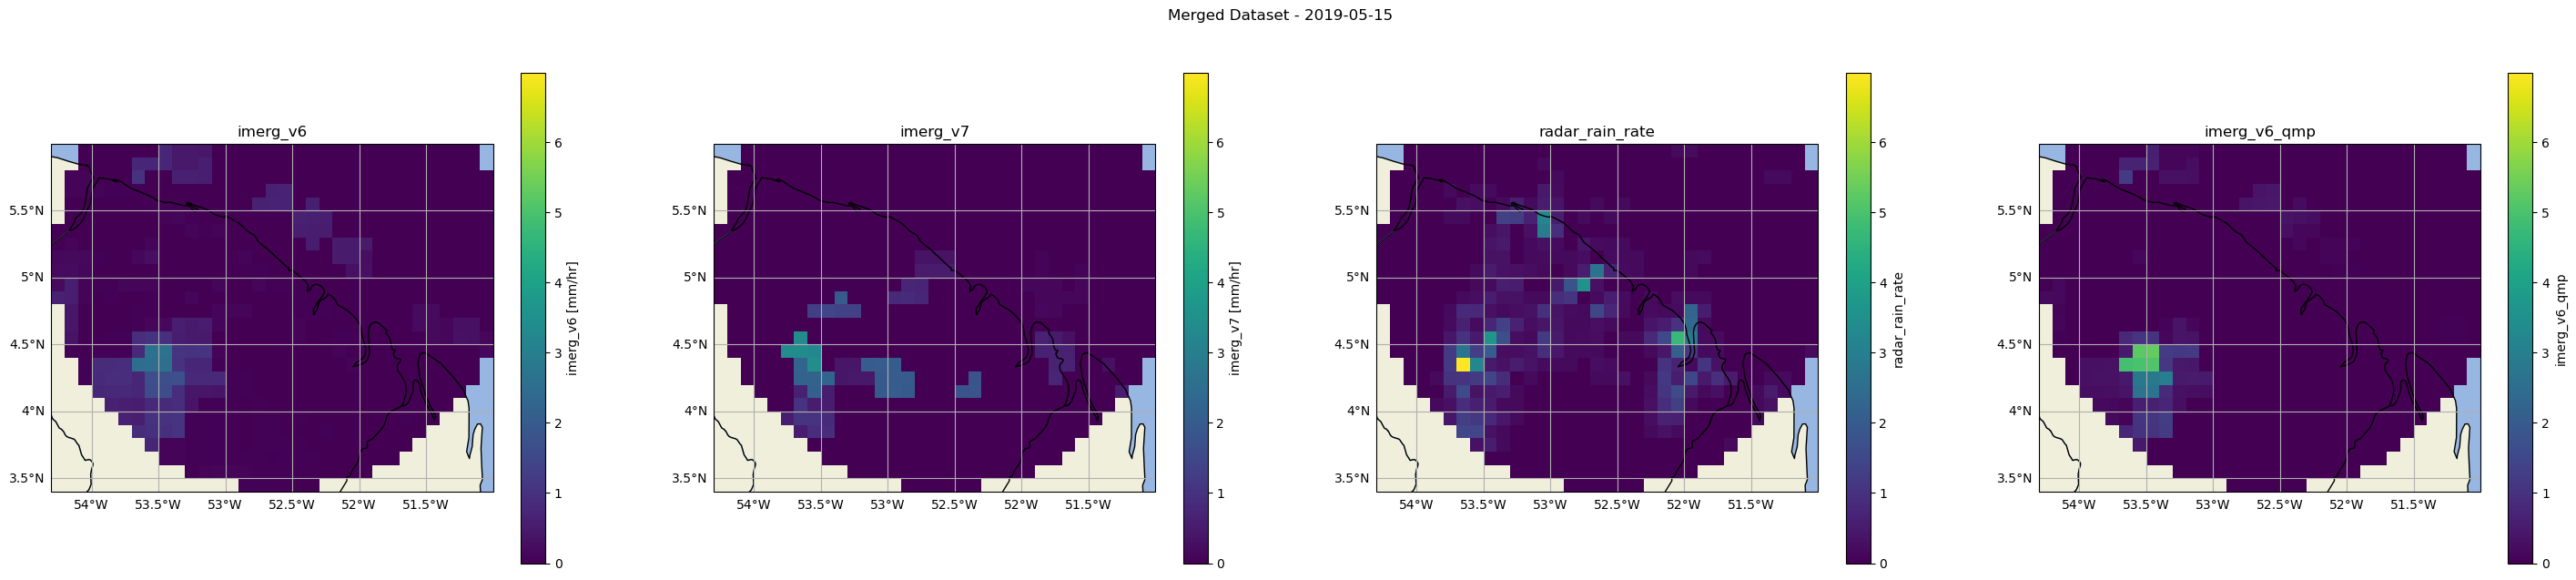

Processing date: 2019-05-21


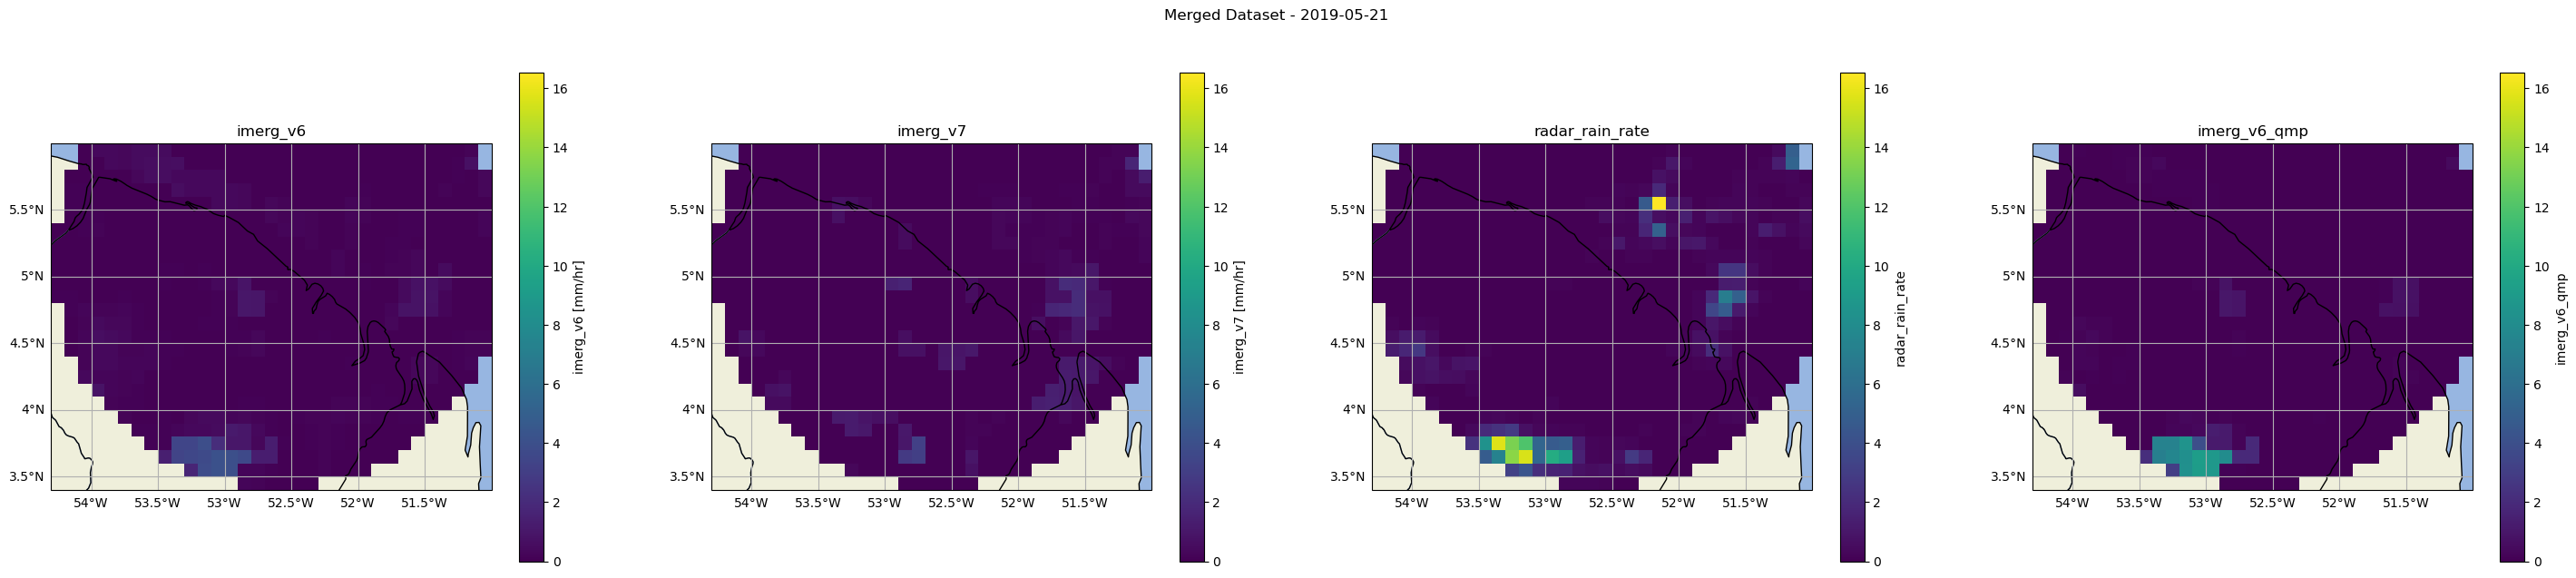

In [7]:
merged_dss = []
for date in dates_intersect:
    print(f'Processing date: {date}')
    merged = create_merged_dataset(satv7, satv6, v6qmp, radar, date)
    gvis.plot_ds(merged.isel(time=0))
    fig = plt.gcf()
    fig.suptitle(f'Merged Dataset - {date}')
    plt.show()

    merged_dss.append(merged)

merged_ds = xr.concat(merged_dss, dim='time')

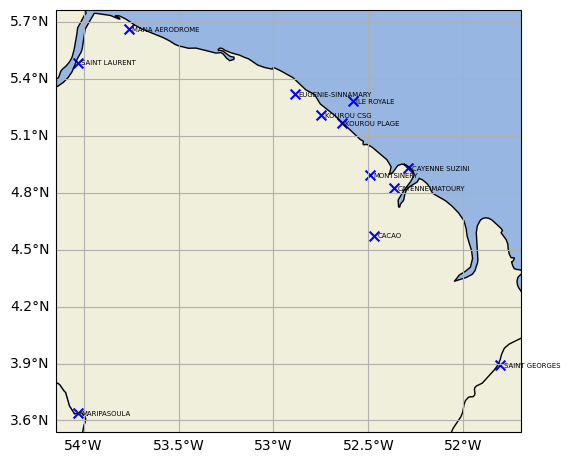

In [34]:
gauges_dates = pd.concat([gauges.data.loc[str(date)] for date in dates_intersect])
# sum 30 min intervals where at least 4 values are present, skip intervals where no data is present
gauges_30min = gauges_dates.groupby(pd.Grouper(freq='30min')).sum(min_count=4)
gauges_30min = pd.concat([gauges_30min.loc[str(date)] for date in dates_intersect])

relevant_metadata = gauges.metadata.loc[~(gauges_30min.sum() == 0)]
relevant_data = gauges_30min.loc[:, relevant_metadata.index]

fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': gvis.ccrs.PlateCarree()})
gvis.plot_simple_map(ax=ax)
gvis.plot_gauge_network(relevant_metadata, ax=ax, display_names=True)

In [37]:
dfs_30min_by_station = {}
dfs_daily_by_station = {}
for station in relevant_data.columns:
    lon, lat = gauges.get_coords_station(station)
    df_rad_sat = gutils.ds_to_df_at_point(ds, (lon, lat))
    df_rad_sat_gau = pd.concat([df_rad_sat, relevant_data.loc[:, station]], axis=1).dropna()
    df_rad_sat_gau = df_rad_sat_gau.rename(columns={station: 'gauge'})
    df_rsg_daily = (df_rad_sat_gau.groupby(pd.Grouper(freq='1d')).sum(min_count=47)/2).dropna()
    dfs_30min_by_station[station] = df_rad_sat_gau
    dfs_daily_by_station[station] = df_rsg_daily

stations_to_drop = [97353001]
for station in stations_to_drop:
    dfs_30min_by_station.pop(station)
    dfs_daily_by_station.pop(station)

all_stations_30min = pd.concat([dfs_30min_by_station[key] for key in dfs_30min_by_station.keys()])
all_stations_daily = pd.concat([dfs_daily_by_station[key] for key in dfs_daily_by_station.keys()])

In [ ]:
sutils.score_rbias(all_stations_30min, 'gauge')

{'imerg_v6': {'relative_bias': np.float64(0.11773728375047857)},
 'imerg_v7': {'relative_bias': np.float64(0.5462174466704154)},
 'radar_rain_rate': {'relative_bias': np.float64(1.4025186143071378)},
 'imerg_v6_qmp': {'relative_bias': np.float64(0.8206268636361892)}}

In [21]:
pd.concat([gauges.data.loc[str(date)] for date in dates_intersect], axis=0)

,97301001,97302001,97302005,97303001,97304001,97304003,97304005,97305001,97305002,97306007,...,97312009,97313001,97353001,97353007,97356001,97356003,97357001,97358001,97360003,97361001
AAAAMMJJHHMN,,,,,,,,,,,,,,,,,,,,,
2019-01-09 00:00:00,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-09 00:06:00,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-09 00:12:00,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-09 00:18:00,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-09 00:24:00,NaN,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-21 23:30:00,NaN,NaN,0.2,NaN,0.0,0.2,0.0,NaN,NaN,0.0,...,1.5,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-21 23:36:00,NaN,NaN,0.0,NaN,0.0,0.4,0.0,NaN,NaN,0.0,...,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-21 23:42:00,NaN,NaN,0.0,NaN,0.0,1.6,0.2,NaN,NaN,0.0,...,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
gauges.metadata.loc[~(gauges_30min.sum() == 0)]

,name,lat,lon,ALTI
NUM_POSTE,,,,
97302005,CAYENNE SUZINI,4.929667,-52.290167,5
97304001,ILE ROYALE,5.283333,-52.583333,48
97304003,KOUROU CSG,5.209167,-52.748000,17
97304005,KOUROU PLAGE,5.168167,-52.640500,3
97306007,MANA AERODROME,5.663500,-53.761667,3
97307001,CAYENNE-MATOURY,4.822333,-52.365333,4
97308001,SAINT GEORGES,3.890667,-51.804667,6
97310006,CACAO,4.574000,-52.471333,6
97311001,SAINT LAURENT,5.485500,-54.031667,5


In [15]:
11*48

528